# Higher Modality Classifier

+ In this notebook we could observe the use of the EfficientNet Class, Data Augmentation and Weight & Bias tracker. Also the sweep function is available in order to tune the hyperparameters od the model (using Grid, Random or Bayes)

### 1. Importing Libraries

In [1]:
import os
import sys
module_path = "../src"
#os.environ["WANDB_SILENT"] = "true" # Environment Variable to make wandb silent
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
# 2. DataModule & Class Libraries
from utils.label_encoder import label_encoder_target
from utils.calc_stat import calc_dataset_mean_std
from dataset.ImageDataModule import ImageDataModule
from dataset.ImageDataset import ImageDataset
from models.EfficientNetClass import EfficientNetClass
from models.ResNetClass import ResNetClass

# 3. Pytorch & Pytorch Lightning Libraries
from pytorch_lightning import Trainer,seed_everything
from torchvision import transforms
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
# 4. Wandb Tracker Experiements
import wandb

### 2. General Variables
 Here we stablish some general variables that will be used in all the experiements.In this case we will have less general variables because we will tune some of them using the sweep api.For example:
 + SEED           : Seed in order to ensure reproducibility
 + PROJECT        : Name of the project
 + NUM_WORKERS    : Number of workers in the cluster
 + METRIC_MONITOR : Metric that will be monitor in the sweep api

In [3]:
BASE_PATH = Path('/mnt')
print(f"My base path is {BASE_PATH}")
DATA_PATH = '../data/higher_modality_vol1.csv'
print(f"The given dataset is located here: {DATA_PATH}")
OUTPUT_DIR = Path('/mnt/artifacts/experiments/')
print(f"Let's use this folder: {OUTPUT_DIR} to save our artifacts.")
BASE_IMG_DIR = BASE_PATH / 'subfigure-classification'       # the image path in the CSV file are relative to this directory


My base path is /mnt
The given dataset is located here: ../data/higher_modality_vol1.csv
Let's use this folder: /mnt/artifacts/experiments to save our artifacts.


In [4]:
SEED = 42 
seed_everything(42)
PROJECT = 'Biomedical-Image-Classification-Higher-Modality'
NUM_WORKERS = 72 # workers on the cluster, normally 2 or 4 on a laptop
METRIC_MONITOR = "val_avg_loss"
OUTPUT_PROJECT = OUTPUT_DIR/PROJECT
print(f"Let's use this folder {OUTPUT_PROJECT} to save our sweep iterations")
os.makedirs(OUTPUT_PROJECT, exist_ok=True) # Check if it is false

Let's use this folder /mnt/artifacts/experiments/Biomedical-Image-Classification-Higher-Modality to save our sweep iterations


### 3. Reading the Data & Label Encoding Classes
In this step, we read the csv file and apply a label encoder to the classes in order to run the classifier

In [5]:
df = pd.read_csv(DATA_PATH, sep='\t')
le_encoder_higher_modality,dict_label = label_encoder_target(df)
df.head()

,img,modality,set,source,img_path,higher_modality,caption,split_set
0,11373_2007_9226_Fig1_HTML-10.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-10.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
1,11373_2007_9226_Fig1_HTML-11.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-11.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
2,11373_2007_9226_Fig1_HTML-12.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-12.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
3,11373_2007_9226_Fig1_HTML-13.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-13.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
4,11373_2007_9226_Fig1_HTML-14.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-14.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN


In [6]:
pd.DataFrame(100*df['higher_modality'].value_counts(normalize = True)).reset_index().rename(columns = {'index':'Features','higher_modality':'Distribution(%)'})

,Features,Distribution(%)
0,GRAPHICS,37.493040
1,ORGANISMS,24.686804
2,MICROSCOPY,22.403953
3,MOLECULAR,5.602728
4,OTHER,5.540089
5,EXPERIMENTAL,4.273385


In [7]:
transform_list = [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
]
transform  = transforms.Compose(transform_list)
train_dataset   = ImageDataset   (DATA_PATH,
                                  le_encoder_higher_modality,
                                  str(BASE_IMG_DIR),
                                  'TRAIN',
                                  image_transform=transform,
                                  label_name='higher_modality',
                                  target_class_col='split_set',
                                  path_col='img_path')

mean, std =calc_dataset_mean_std(train_dataset, batch_size=32, num_workers=1)
print(f"Mean:  {mean}")
print(f"Std :  {std}")


Mean:  tensor([0.6420, 0.6370, 0.6353])
Std :  tensor([0.3706, 0.3698, 0.3734])


### 4. Sweep Running
+ First We will define the image transformations that we are goint to use for the training , evaluation and test


In [7]:
# Image Transformations
# 1.1 Train Transformations
mean = [0.4857, 0.4740, 0.4755]
std  = [0.3648, 0.3557, 0.3669]
train_transform = [
                    transforms.ToPILImage(),
                    transforms.Resize((256, 256)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(15),
                    transforms.CenterCrop((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean,std)
                ]
train_transform  = transforms.Compose(train_transform )

# 1.2 Valid Transformations
val_transform = [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
                ]
val_transform = transforms.Compose(val_transform)

# 1.3 Test Transformations
test_transform = [
                  transforms.ToPILImage(),
                  transforms.Resize((224, 224)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean,std)
                  ]
test_transform = transforms.Compose(test_transform)

+ Second we define the YAML file  structure that is going to be used for tuning Hyperarameters. In this case we are going to run the Grid Method

In [8]:
print(f"PROJECT NAME: {PROJECT}")
print(f"Metric Monitor: {METRIC_MONITOR}")

PROJECT NAME: Biomedical-Image-Classification-Higher-Modality
Metric Monitor: val_avg_loss


### 4.1 ResNet


In [9]:
sweep_config = {
  "method": "grid",   # Random search
  "metric": {           # We want to maximize val_acc
      "name": METRIC_MONITOR, # Used accuracy
      "goal": "minimize"
  },
  "parameters": {
        "lr": {
            # log uniform distribution between exp(min) and exp(max)
            "distribution": "categorical",
            "values" : [0.00001]
        },
        "fine_tuned_from":{
            "distribution": "categorical",
            "values" : ["whole"]
        },
        "name":{
            "distribution": "categorical",
            "values" : ['resnet101']
        },
        "batch_size":{
            "distribution": "categorical",
            "values" : [32]
            
        }
      
    }
}

In [25]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: vp8owwaa
Sweep URL: https://wandb.ai/williamberrios/Biomedical-Image-Classification-Higher-Modality/sweeps/vp8owwaa


In [26]:
OUTPUT_SWEEP = OUTPUT_PROJECT / sweep_id
os.makedirs(OUTPUT_SWEEP, exist_ok=False) # Check if it is false
with open(OUTPUT_SWEEP / 'sweep_config.yml', 'w') as outfile:
    yaml.dump(sweep_config, outfile, default_flow_style=False)

In [27]:
def sweep_iteration():
    # set up W&B logger
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger =  WandbLogger(project=PROJECT, tags=['nb', 'higher-modality'],reinit = True)
    wandb_logger.experiment.save()
    print(f"Name of the Experiment: {wandb_logger.experiment.name}")
    output_run_path = OUTPUT_SWEEP / wandb_logger.experiment.name 
    os.makedirs(output_run_path, exist_ok=False) # Check if it is false

    # setup data
    dm = ImageDataModule( batch_size       = wandb.config.batch_size,
                          label_encoder    = le_encoder_higher_modality,
                          data_path        = str(DATA_PATH), 
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [train_transform,val_transform,test_transform],
                          num_workers      = 1,
                          target_class_col ='split_set',
                          modality_col     ='higher_modality',
                          path_col         ='img_path')
    dm.prepare_data()
    dm.setup()
    dm.set_seed()
    # Callbacks
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    early_stop_callback = EarlyStopping(
        monitor=METRIC_MONITOR,
        min_delta=0.0,
        patience=5,
        verbose=True,
        mode='min'
    )
    # setup model - note how we refer to sweep parameters with wandb.config
    num_classes = len(df.higher_modality.unique())
    model = ResNetClass      (name            = wandb.config.name,
                              num_classes     = num_classes,
                              pretrained      = True,
                              fine_tuned_from = wandb.config.fine_tuned_from,
                              lr              = wandb.config.lr,
                              metric_monitor  = METRIC_MONITOR,
                              mode_scheduler  = "min",
                              class_weights   = dm.class_weights,
                              mean_dataset    = mean,
                              std_dataset     = std)


    # setup Trainer
    trainer = Trainer(gpus=1,
                  max_epochs=100,                  
                  callbacks=[early_stop_callback,lr_monitor],
                  deterministic= True,
                  logger=wandb_logger,
                  num_sanity_val_steps=0)

    # train
    trainer.fit(model, dm)
    # Save the model
    trainer.save_checkpoint(str(output_run_path / 'final.pt'))
    # Get testS metric
    trainer.test(model, test_dataloaders=dm.val_dataloader())
    del model
    wandb.finish()


Name of the Experiment: iconic-sweep-1


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 42.5 M
-----------------------------------------------
42.5 M    Trainable params
0         Non-trainable params
42.5 M    Total params


Epoch     8: reducing learning rate of group 0 to 1.0000e-06.


Accuracy: 94.30656433105469
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92        78
         1.0       0.97      0.94      0.95       651
         2.0       0.97      0.97      0.97       469
         3.0       0.82      0.89      0.85       109
         4.0       0.98      0.97      0.97       612
         5.0       0.74      0.76      0.75       136

    accuracy                           0.94      2055
   macro avg       0.89      0.92      0.90      2055
weighted avg       0.94      0.94      0.94      2055


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9183998110614139,
 'Macro F1-Score': 0.9039487859328278,
 'test_acc': tensor(94.3066, device='cuda:0'),
 'test_loss': tensor(0.2518, device='cuda:0')}
--------------------------------------------------------------------------------


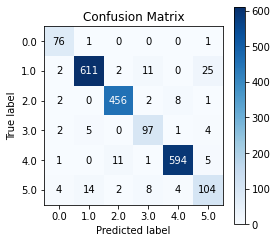

In [13]:
wandb.agent(sweep_id, function=sweep_iteration);

### 4.2 EfficientNet


In [10]:
sweep_config = {
  "method": "grid",   # Random search
  "metric": {           # We want to maximize val_acc
      "name": METRIC_MONITOR, # Used accuracy
      "goal": "minimize"
  },
  "parameters": {
        "lr": {
            # log uniform distribution between exp(min) and exp(max)
            "distribution": "categorical",
            "values" : [1e-5]
        },
        "fine_tuned_from":{
            "distribution": "categorical",
            "values" : ["whole"]
        },
        "name":{
            "distribution": "categorical",
            "values" : ["efficientnet-b1"]
        },
        "batch_size":{
            "distribution": "categorical",
            "values" : [32]
            
        }
      
    }
}

In [11]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: akhi1kq7
Sweep URL: https://wandb.ai/williamberrios/Biomedical-Image-Classification-Higher-Modality/sweeps/akhi1kq7


In [12]:
OUTPUT_SWEEP = OUTPUT_PROJECT / sweep_id
os.makedirs(OUTPUT_SWEEP, exist_ok=False) # Check if it is false
with open(OUTPUT_SWEEP / 'sweep_config.yml', 'w') as outfile:
    yaml.dump(sweep_config, outfile, default_flow_style=False)

In [13]:
def sweep_iteration():
    # set up W&B logger
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger =  WandbLogger(project=PROJECT, tags=['nb', 'higher-modality'],reinit = True)
    wandb_logger.experiment.save()
    print(f"Name of the Experiment: {wandb_logger.experiment.name}")
    output_run_path = OUTPUT_SWEEP / wandb_logger.experiment.name 
    os.makedirs(output_run_path, exist_ok=False) # Check if it is false

    # setup data
    dm = ImageDataModule( batch_size       = wandb.config.batch_size,
                          label_encoder    = le_encoder_higher_modality,
                          data_path        = str(DATA_PATH), 
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [train_transform,val_transform,test_transform],
                          num_workers      = 1,
                          target_class_col ='split_set',
                          modality_col     ='higher_modality',
                          path_col         ='img_path')
    dm.prepare_data()
    dm.setup()
    dm.set_seed()
    # Callbacks
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    early_stop_callback = EarlyStopping(
        monitor=METRIC_MONITOR,
        min_delta=0.0,
        patience=5,
        verbose=True,
        mode='min'
    )
    # setup model - note how we refer to sweep parameters with wandb.config
    num_classes = len(df.higher_modality.unique())
    model = EfficientNetClass(name            = wandb.config.name,
                              num_classes     = num_classes,
                              pretrained      = True,
                              fine_tuned_from = wandb.config.fine_tuned_from,
                              lr              = wandb.config.lr,
                              metric_monitor  = METRIC_MONITOR,
                              mode_scheduler  = "min",
                              class_weights   = dm.class_weights,
                              mean_dataset    = mean,
                              std_dataset     = std)
    
    # setup Trainer
    trainer = Trainer(gpus=1,
                  max_epochs=100,                  
                  callbacks=[early_stop_callback,lr_monitor],
                  deterministic= True,
                  logger=wandb_logger,
                  num_sanity_val_steps=0)

    # train
    trainer.fit(model, dm)
    # Save the model
    trainer.save_checkpoint(str(output_run_path / 'final.pt'))
    # Get testS metric
    trainer.test(model, test_dataloaders=dm.val_dataloader())
    del model
    wandb.finish()


wandb: Agent Starting Run: s318s7pe with config:
wandb: 	batch_size: 32
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-05
wandb: 	name: efficientnet-b1
wandb: Currently logged in as: williamberrios (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


Name of the Experiment: wobbly-sweep-1


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded pretrained weights for efficientnet-b1


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | EfficientNet     | 6.5 M 
-----------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:

Epoch    33: reducing learning rate of group 0 to 1.0000e-06.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Accuracy: 93.5766372680664
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94        78
         1.0       0.97      0.92      0.94       651
         2.0       0.98      0.95      0.96       469
         3.0       0.77      0.90      0.83       109
         4.0       0.97      0.98      0.97       612
         5.0       0.69      0.79      0.74       136

    accuracy                           0.94      2055
   macro avg       0.88      0.91      0.90      2055
weighted avg       0.94      0.94      0.94      2055


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9148547175434177,
 'Macro F1-Score': 0.8974478433671257,
 'test_acc': tensor(93.5766, device='cuda:0'),
 'test_loss': tensor(0.2444, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,17475
_runtime,2145
_timestamp,1612898384
val_acc,93.57664
val_avg_loss,0.2444
epoch,33
train_acc,96.17819
train_avg_loss,0.10564
test_acc,93.57664
test_loss,0.2444


lr-Adam,█████████████████████████████████▁
_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄█
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████
val_avg_loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train_acc,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
train_avg_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


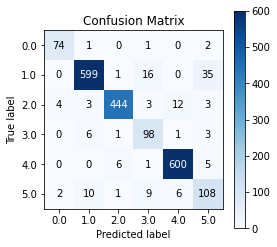

In [14]:
wandb.agent(sweep_id, function=sweep_iteration);